# Air Pressure System(APS) failure in Scania Trucks Prediction

### 1) Problem Statement

The dataset consists of data collected from heavy Scania trucks during everyday usage. The system in focus is the **Air Pressure System (APS)**, which generates pressurised air used in various truck functions, such as braking and gear changes.

- The **positive class** corresponds to component failures in a specific part of the APS system.
- The **negative class** corresponds to failures in components **not** related to the APS system.
- The dataset includes a **subset of all available data**, selected by domain experts.

---

### 📊 Challenge Metric

**Cost-metric of Misclassification:**

| Predicted Class | True: pos | True: neg |
|-----------------|-----------|-----------|
| **pos**         |     -     |  Cost_1 = 10  |
| **neg**         |  Cost_2 = 500 |     -     |

- **Cost_1**: Cost incurred due to unnecessary mechanic inspection.
- **Cost_2**: Cost incurred by **missing a faulty truck**, potentially leading to breakdowns.

🔸 **Total Cost Formula:**

\[
\text{Total\_cost} = (\text{Cost}_1 \times \text{False Positives}) + (\text{Cost}_2 \times \text{False Negatives})
\]

⚠️ Since **Cost_2 is 50x higher** than Cost_1, the primary goal is to **reduce false negatives**, while still minimizing false positives.

---

### 2) Dataset Overview

- **Training Set**: 60,000 instances  
- **Features**: 171 total features  
- **Target Label**: 1 binary class label (`pos` / `neg`)


**Import important Libraries**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix, precision_recall_curve
import xgboost

from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer


warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df= pddf=pd.read_csv(f"/kaggle/input/aps-failure-at-scania-trucks-data-set/aps_failure_training_set.csv")

In [3]:
df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


### Checking rows and columns in dataset

In [4]:
df.shape

(60000, 171)

#### Unique values present in dependent column

In [5]:
df['class'].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

#### Observation:
Data is highly imbalance on the bases of target columns as negative values are approx 60 times more than positive values in target column.

#### Checking % of positive class 

In [6]:
import math
per_pos_class = ((df['class']=='pos').sum()/df.shape[0])*100
print(round(per_pos_class,2),"%")

1.67 %


In [7]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 1 numerical features : ['aa_000']

We have 170 categorical features : ['class', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_

## Cleaning Data

In [8]:
# replacing all na values with nan(null)
df=df.replace('na',np.nan)

In [9]:
# Converting all datatypes all columns to float exluding class column

for feature in df.columns:
    if df[feature].dtype == 'O' and feature!='class':
        df[feature]=df[feature].astype(float)

In [10]:
#numerical features count
numerical_features = [feature for feature in df.columns if df[feature].dtype!='O']
print(len(numerical_features))

170


### Checking % of missing values in each column

In [11]:
missing_values = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0,ascending= False)

### Dropping columns where missing vlaues are more than 70%

In [12]:
drop_cols=missing_values[missing_values[0]>65]
print(list(drop_cols.index))

['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'bm_000']


In [13]:
df.drop(list(drop_cols.index),axis=1, inplace=True)

In [14]:
#Checking number of columns after dropping null values columns
df.shape

(60000, 163)

### Checking % of missing cells in dataset

In [15]:
total_missing_cells= df.isnull().sum().sum()
total_cells = np.product(df.shape)
missing_cell_per = (total_missing_cells/total_cells)*100
print(f"there are {round(missing_cell_per)}% missing cells in data")

there are 5% missing cells in data


### Saving Cleaned data to the system

In [16]:
df.to_csv("APS_data_cleaned", index=False)

## Statistical Analysis of Data

In [17]:
df.describe()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,5.933650e+04,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,1.454301e+05,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,2.374282e+06,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.080000e+02,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.672000e+03,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.952200e+04,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,2.746564e+06,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,2.288306e+08,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


In [18]:
# Checking memory usage of each column
df.memory_usage()

Index        128
class     480000
aa_000    480000
ac_000    480000
ad_000    480000
           ...  
ee_007    480000
ee_008    480000
ee_009    480000
ef_000    480000
eg_000    480000
Length: 164, dtype: int64

### Visualization of unique values in Target variable

Text(0.5, 1.0, 'neg:59000 / pos:1000')

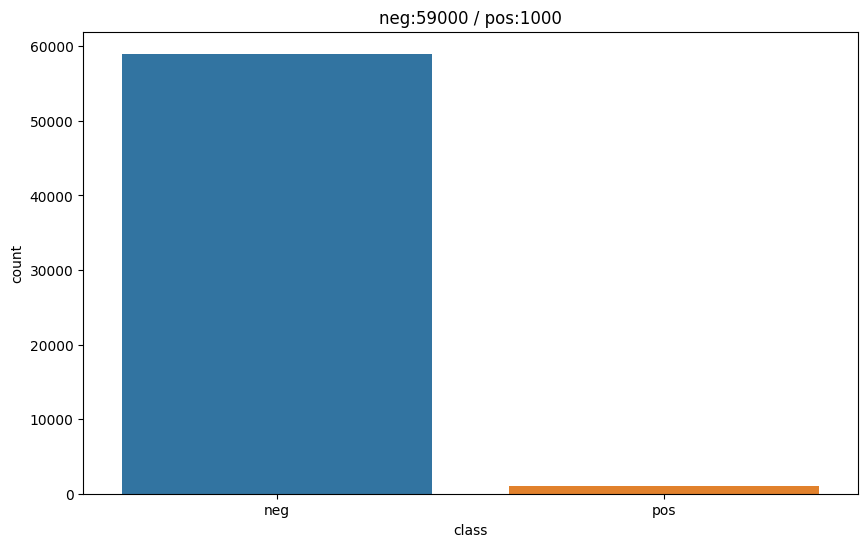

In [19]:
plt.figure(figsize=(10,6))
sns.countplot(x=df["class"])
plt.title("neg:{0} / pos:{1}".format(df['class'].value_counts()[0], df["class"].value_counts()[1]))

As dataset is highly imbalanced. We need to overcome this issue by resampling techniques

## Model Evaluation with random forest

In [20]:
# Prepare Data
# Split features and target
X = df.drop('class', axis=1)
y = df['class']  # 'pos' / 'neg'

In [21]:
# Split data (stratified is better if classes are imbalanced)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=10
)


In [22]:
#Impute Missing Values Using median imputation

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [23]:
#Handle Imbalanced Data with SMOTE
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)


In [24]:
#Train Random Forest Classifier


model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [25]:
# Predict on Test Set (With Threshold 0.3)

y_probs = model.predict_proba(X_test_imputed)[:, 1]  # Probabilities for class 'pos'
y_pred = (y_probs >= 0.3).astype(int)  # Custom threshold to reduce false negatives

# Convert y_test ('neg'/'pos') to numeric (0/1)
y_test = (y_test == "pos").astype(int)

### Evaluation matrix for Random Forest


🔹 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19465
           1       0.48      0.92      0.63       335

    accuracy                           0.98     19800
   macro avg       0.74      0.95      0.81     19800
weighted avg       0.99      0.98      0.98     19800



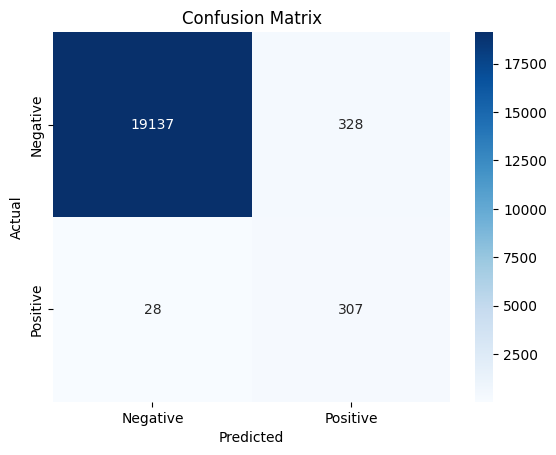

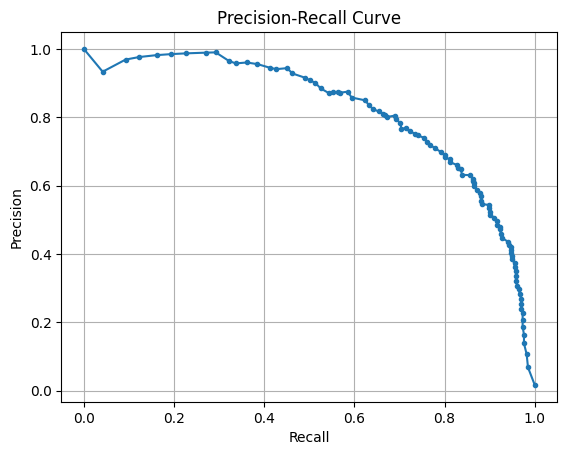


🔹 ROC AUC Score: 0.9856


In [26]:
# Classification report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Precision-Recall Curve

precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"\n🔹 ROC AUC Score: {roc_auc:.4f}")

#### Cost Evaluation

In [27]:
# Cost Evaluation

# Get confusion matrix values
tn, fp, fn, tp = cm.ravel()

# Define custom cost formula
Total_cost = (10 * fp) + (500 * fn)
print(f"🔹 Total Cost of False Positives & Negatives: Rs. {Total_cost} /-")

🔹 Total Cost of False Positives & Negatives: Rs. 17280 /-


#### Train/Test Accuracy

In [28]:
# Predict on training data
train_preds = model.predict(X_train_resampled)

# Predict on test data with 0.5 threshold (for accuracy only)
test_preds = model.predict(X_test_imputed)
test_preds = np.where(test_preds == "pos", 1, 0)  # Ensure numeric format

print(f"\n🔹 Training Accuracy: {accuracy_score(y_train_resampled, train_preds):.4f}")
print(f"🔹 Test Accuracy (threshold=0.5): {accuracy_score(y_test, test_preds):.4f}")


🔹 Training Accuracy: 1.0000
🔹 Test Accuracy (threshold=0.5): 0.9900


#### Observation:
As the training accuracy of the model is 100%. This could be the case of overfitting due to the leakage of data. We can try with other regularized model(eg:XGboost)

### Individual Matrix
Checking precision and recall values as we need to reduce false negative, recall value must be higher 

In [29]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

print(f"\nPrecision (pos class): {precision:.4f}")
print(f"Recall (pos class):    {recall:.4f}")
print(f"F1 Score:              {f1:.4f}")
print(f"ROC AUC Score:         {roc_auc:.4f}")


Precision (pos class): 0.4835
Recall (pos class):    0.9164
F1 Score:              0.6330
ROC AUC Score:         0.9856


#### Checking Precision and recall values on different threshold

In [30]:
thresholds = np.arange(0, 1, 0.05)
for thresh in thresholds:
    temp_pred = (y_probs >= thresh).astype(int)
    p = precision_score(y_test, temp_pred)
    r = recall_score(y_test, temp_pred)
    print(f"Threshold: {thresh:.2f} -> Precision: {p:.3f}, Recall: {r:.3f}")


Threshold: 0.00 -> Precision: 0.017, Recall: 1.000
Threshold: 0.05 -> Precision: 0.187, Recall: 0.973
Threshold: 0.10 -> Precision: 0.268, Recall: 0.970
Threshold: 0.15 -> Precision: 0.350, Recall: 0.958
Threshold: 0.20 -> Precision: 0.393, Recall: 0.949
Threshold: 0.25 -> Precision: 0.436, Recall: 0.940
Threshold: 0.30 -> Precision: 0.498, Recall: 0.916
Threshold: 0.35 -> Precision: 0.543, Recall: 0.899
Threshold: 0.40 -> Precision: 0.580, Recall: 0.878
Threshold: 0.45 -> Precision: 0.620, Recall: 0.863
Threshold: 0.50 -> Precision: 0.661, Recall: 0.827
Threshold: 0.55 -> Precision: 0.699, Recall: 0.791
Threshold: 0.60 -> Precision: 0.752, Recall: 0.734
Threshold: 0.65 -> Precision: 0.783, Recall: 0.701
Threshold: 0.70 -> Precision: 0.817, Recall: 0.654
Threshold: 0.75 -> Precision: 0.858, Recall: 0.594
Threshold: 0.80 -> Precision: 0.871, Recall: 0.543
Threshold: 0.85 -> Precision: 0.944, Recall: 0.451
Threshold: 0.90 -> Precision: 0.960, Recall: 0.361
Threshold: 0.95 -> Precision: 0

Threshold=0.30 will be the best threshold in our case

#### Evaluating with XGboost model

In [31]:
# Load Data
X = df.drop('class', axis=1)
y = (df['class'] == 'pos').astype(int)  # Convert to binary (0 = neg, 1 = pos)


In [32]:
# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [33]:
#Missing Value imputation
imputer = SimpleImputer(strategy="median") 
X_train_imputed = imputer.fit_transform(X_train)  
X_test_imputed = imputer.transform(X_test)

In [34]:
# Step 3: SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)


In [35]:
# Train XGBoost Model
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Balance classes
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [36]:
# Predict Probabilities and Apply Custom Threshold
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.3).astype(int)

#### Evaluation matrix for XGBoost

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     17700
           1       0.26      0.84      0.39       300

    accuracy                           0.96     18000
   macro avg       0.63      0.90      0.69     18000
weighted avg       0.98      0.96      0.97     18000



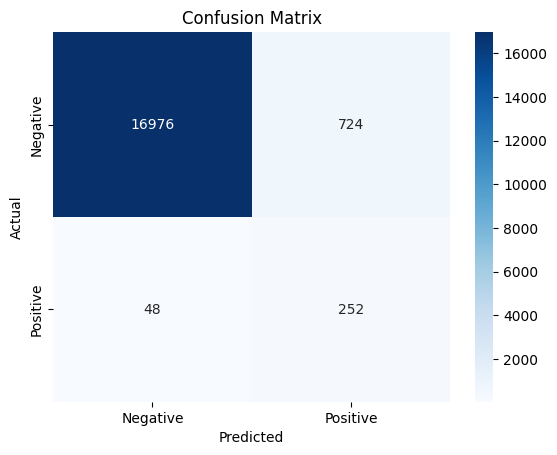

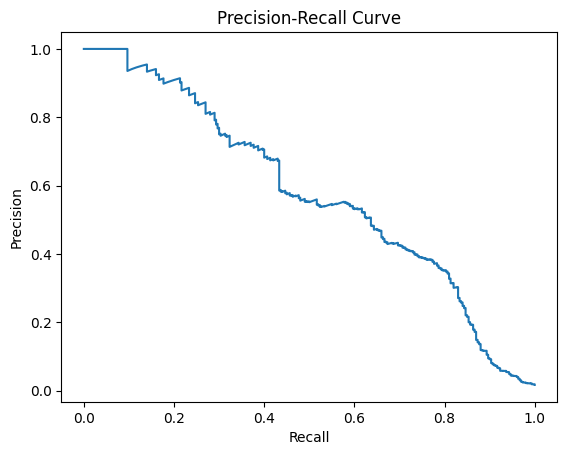

ROC AUC Score: 0.9460


In [37]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")



#### Train/Test Accuracy

In [38]:
train_preds = model.predict(X_train_resampled)
test_preds = model.predict(X_test_imputed)

test_preds = np.where(test_preds == "pos", 1, 0)

print("Train Accuracy:", accuracy_score(y_train_resampled, train_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))

Train Accuracy: 0.9885351089588378
Test Accuracy: 0.9833333333333333


#### Evaluating Cost

In [39]:
tp,fp,fn,tn=cm.ravel()
Total_cost_gr = 10*fp + 500 *fn
print(f"Total cost of repair of gradiend boost = Rs. {Total_cost_gr} /-")

Total cost of repair of gradiend boost = Rs. 31240 /-


#### Individual Metrics

In [40]:
print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['neg', 'pos']))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

print(f"\nPrecision (pos class): {precision:.4f}")
print(f"Recall (pos class):    {recall:.4f}")
print(f"F1 Score:              {f1:.4f}")
print(f"ROC AUC Score:         {roc_auc:.4f}")


🔍 Classification Report:
              precision    recall  f1-score   support

         neg       1.00      0.96      0.98     17700
         pos       0.26      0.84      0.39       300

    accuracy                           0.96     18000
   macro avg       0.63      0.90      0.69     18000
weighted avg       0.98      0.96      0.97     18000


Precision (pos class): 0.2582
Recall (pos class):    0.8400
F1 Score:              0.3950
ROC AUC Score:         0.9460


In [41]:
thresholds = np.arange(0, 1, 0.05)
for thresh in thresholds:
    temp_pred = (y_probs >= thresh).astype(int)
    p = precision_score(y_test, temp_pred)
    r = recall_score(y_test, temp_pred)
    print(f"Threshold: {thresh:.2f} -> Precision: {p:.3f}, Recall: {r:.3f}")


Threshold: 0.00 -> Precision: 0.017, Recall: 1.000
Threshold: 0.05 -> Precision: 0.093, Recall: 0.900
Threshold: 0.10 -> Precision: 0.142, Recall: 0.873
Threshold: 0.15 -> Precision: 0.180, Recall: 0.863
Threshold: 0.20 -> Precision: 0.206, Recall: 0.853
Threshold: 0.25 -> Precision: 0.234, Recall: 0.847
Threshold: 0.30 -> Precision: 0.258, Recall: 0.840
Threshold: 0.35 -> Precision: 0.277, Recall: 0.830
Threshold: 0.40 -> Precision: 0.295, Recall: 0.830
Threshold: 0.45 -> Precision: 0.311, Recall: 0.820
Threshold: 0.50 -> Precision: 0.330, Recall: 0.810
Threshold: 0.55 -> Precision: 0.347, Recall: 0.807
Threshold: 0.60 -> Precision: 0.364, Recall: 0.787
Threshold: 0.65 -> Precision: 0.382, Recall: 0.773
Threshold: 0.70 -> Precision: 0.397, Recall: 0.737
Threshold: 0.75 -> Precision: 0.418, Recall: 0.707
Threshold: 0.80 -> Precision: 0.440, Recall: 0.667
Threshold: 0.85 -> Precision: 0.500, Recall: 0.637
Threshold: 0.90 -> Precision: 0.534, Recall: 0.597
Threshold: 0.95 -> Precision: 0

Report comparing the two models, focusing on key evaluation metrics and aligned with the goal of **minimizing false negatives** due to high cost:

---

## 🧾 **Model Comparison Report: Random Forest vs XGBoost**

### 📌 **Objective**
To evaluate two classification models (Random Forest and XGBoost) trained on a highly imbalanced dataset, where the **positive class comprises only 1.67%** of the data. The primary goal is to **minimize false negatives**, as they incur **high cost** in the business scenario.

---

### 🔍 **Scenario Overview**

| Metric                        | **Scenario 1** (Random Forest) | **Scenario 2** (XGBoost) |
|------------------------------|------------------------------|--------------------------|
| **Training Accuracy**        | 100%                          | 99%                      |
| **Testing Accuracy**         | 99%                           | 98%                      |
| **Precision (Positive Class)** | **0.4835**                    | 0.2582                   |
| **Recall (Positive Class)**    | **0.9164** ✅                 | 0.8400                   |
| **F1 Score**                   | **0.6330**                    | 0.3950                   |
| **ROC AUC Score**             | **0.9856**                    | 0.9460                   |

---

### 🧠 **Interpretation & Analysis**

#### ✅ **Scenario 1 (Random Forest):**
- Achieves **exceptional recall** of **91.6%**, meaning it successfully identifies the majority of positive cases — which is **critical** to reducing false negatives.
- The precision of **48.35%** indicates that nearly **half of the predicted positives are correct**, a **reasonable trade-off** given the extreme class imbalance.
- The **F1 score** and **ROC AUC** are both **significantly higher**, showing strong overall model balance and ability to separate classes.
- The **training accuracy of 100%** may suggest slight overfitting, but the **excellent test performance** indicates that the model still generalizes well.

#### ⚠️ **Scenario 2 (XGBoost):**
- Delivers good performance with **84% recall**, but it falls short in minimizing false negatives compared to Scenario 1.
- **Precision (25.82%)** is relatively low, meaning more false positives are being produced.
- Lower **F1 score (0.3950)** and **ROC AUC (0.9460)** reflect reduced overall performance and less effective discrimination between classes.

---

### 🏁 **Conclusion**

> **Scenario 1 (Random Forest)** is the preferred model based on:
- Superior **recall**, ensuring most positive cases are detected
- Higher **precision**, **F1 score**, and **AUC**, indicating better balance and performance
- Best alignment with business objective: **reducing false negatives**

---

### 📌 **Recommendation**
- Proceed with **Random Forest (Scenario 1)**.
- Continue monitoring performance on unseen data using cross-validation or out-of-fold validation.
- Consider further optimizing the threshold or applying cost-sensitive evaluation to fine-tune the trade-off between false positives and false negatives.
